### Set path to a data file

In [1]:
import os, sys

# Add the project root to sys.path so I can import submodules
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import src.active_learning.acquisition as aq
import src.active_learning.gaussian_process as gpc
import src.visualization.plot as pl

# Define the home directory and path to data
home_dir = os.path.expanduser("~")

# Target metric: initial CO2 conversion
# path = (home_dir +
#         "/Dropbox/0.Dongjae/04.SUNCAT@SLAC,Standford(2402~)/231128_research/240602_ML_codes/CatDegUS/src/tests/20250228_sheet_for_ML_unique.xlsx")
path = "./20250228_sheet_for_ML_unique.xlsx"

/Users/djayshin/miniconda3/envs/catdegus/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocess data and train a Gaussian process model 
* `path`: path to data file (excel)

In [2]:
# Train the Gaussian Process model
GP = gpc.GaussianProcess()
GP.preprocess_data_at_once(path=path,
                           target='CO2 Conversion (%)_initial value',
                           x_range_min=[300, 0.1, 0.005, 0], x_range_max=[550, 1.0, 0.02, 1])
GP.train_gp()

self.df.dtypes: reaction_temp                         int64
Rh_weight_loading                   float64
Rh_total_mass                       float64
synth_method                          int64
CO2 Conversion (%)_initial value    float64
dtype: object
numerical_features (selected):  ['reaction_temp', 'Rh_weight_loading', 'Rh_total_mass', 'synth_method']
categorical_features (selected):  []


/Users/djayshin/Dropbox/0.Dongjae/04.SUNCAT@SLAC,Standford(2402~)/231128_research/240602_ML_codes/CatDegUS/src/active_learning/gaussian_process.py:92: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df.replace(
/Users/djayshin/miniconda3/envs/catdegus/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but FunctionTransformer was fitted with feature names
  warnings.warn(
/Users/djayshin/miniconda3/envs/catdegus/lib/python3.13/site-packages/botorch/models/utils/assorted.py:270: InputDataWarning: Data (input features) is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(


SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): LogNormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): RBFKernel(
    (lengthscale_prior): LogNormalPrior()
    (raw_lengthscale_constraint): GreaterThan(2.500E-02)
  )
  (outcome_transform): Standardize()
)

### Construct a discrete grid for the optimization of an acquisition function
* Acquisition function to optimize is set by choosing `optimize_*` method.
* Then, maximizer condition of the selected acquisition function (`PosteriorStandardDeviation` in this example) is printed.

In [3]:
# Construct the discrete grid for optimization
Grid = aq.DiscreteGrid(
    GP=GP,
    x_range_min=[300, 0.1, 0.005, 0], x_range_max=[550, 1.0, 0.02, 1], x_step=[50, 0.1, 0.0025, 1]
)
Grid.construct_grid()

Grid.optimize_posterior_std_dev_discrete(synth_method='NP', n_candidates=5)
# Grid.optimize_upper_confidence_bound_discrete(synth_method='NP', n_candidates=5)

840 combinations are possible in the constructed grid.


,reaction_temp,Rh_weight_loading,Rh_total_mass,synth_method,Posterior Standard Deviation
413,550,1.0,0.0050,1,0.999253
414,550,1.0,0.0075,1,0.991565
415,550,1.0,0.0100,1,0.983061
416,550,1.0,0.0125,1,0.973855
41,300,0.6,0.0200,1,0.971450


### Plot the acquisition function
* The acquisition function was determined by a `DiscreteGrid` instance, e.g., `PosteriorStandardDeviation`

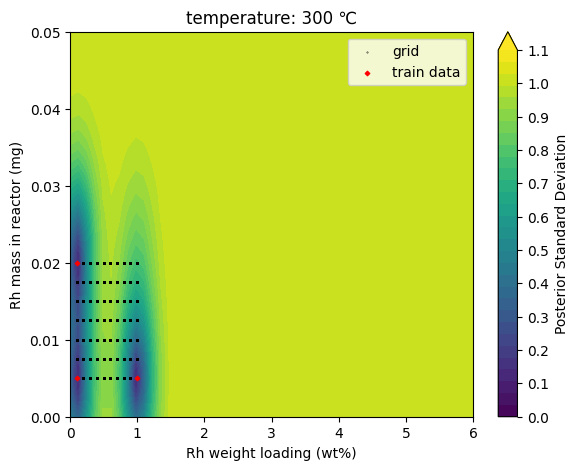

In [4]:
# Plot the acquisition function
Plot = pl.Plotter(GP=GP, Grid=Grid)
Plot.plot_2d_acquisition_function(
    synth_method='WI',
    acq_max=1.1,
    n_levels=32,
    temperature_list=[300], #350, 400, 450, 500, 550],
    mode='custom', #'boundary',
    custom_range=(0.0, 6.0, 0.0, 0.05),  # Custom range for contour plot
    contour_resolution=50
)
